## Применим к картинкам модель VGG16

In [11]:
'''Импорты для препроцессинга'''
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input

In [12]:
'''Импорты моделей'''
from keras.applications.vgg16 import VGG16 
from keras.models import Model

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [13]:
'''Импорты базовых библиотек для обработки данных'''
import os
import numpy as np
from numpy import savetxt
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import cv2
import re
import csv

In [14]:
'''Импорты для визуализации'''
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
from bokeh.plotting import ColumnDataSource, figure, output_file, show
from bokeh.transform import factor_cmap

In [15]:
'''Функция создает список shots, в котором лежат названия файлов кадров'''
def add_image_names_2_list(path):
    # change the working directory to the path where the images are located
    os.chdir(path)

    # this list holds all the image filename
    shots = []

    # creates a ScandirIterator aliased as files
    with os.scandir(path) as files:
      # loops through each file in the directory
        for file in files:
            if file.name.endswith('.jpg'):
              # adds only the image files to the flowers list
                shots.append(file.name)
    return shots

In [16]:
'''Features - признаки объекта, получение сжатия размерности. В данной функции мы загружаем изображение,
предобрабатываем его с помощью встроенных методов keras, изменяем размерность, потому что нейронная сеть работает
только с изображениями определенных форматов'''
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

# Фильм 2012 года

In [33]:
'''Путь к кадрам фильма'''
path = '/Users/tonleon/Documents/GitHub/Diploma/Films/2012_frames'
shots = add_image_names_2_list(path)

In [26]:
'''Путь к нейронке'''
weights_path = '/Users/tonleon/Documents/GitHub/Diploma/vgg16_weights_tf_dim_ordering_tf_kernels.h5'

In [27]:
'''Загружаем модель'''
model = VGG16(weights = weights_path)
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [9]:
'''Энергозатратный чанк, изменяет размерность каждого фрейма'''
data = {}

for shot in shots:
    feat = extract_features(shot, model)
    data[shot] = feat

filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape   

(7764, 4096)

In [16]:
'''На всякий случай сохраняю в csv полученные данные, чтобы далее работать с ними'''
file = csv.writer(open("/Users/tonleon/Documents/GitHub/Diploma/Films/Data/Features_2012.csv", "w"))
for key, val in data.items():
    file.writerow([key, val])

### Применим PCA к предобработанным нейронной сетью изображениям

In [18]:
'''С помощью PCA еще раз изменяем размерность матрицы'''
pca = PCA(n_components=150, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

array([[-1.1924257e+01, -3.1449945e+00, -1.4910715e+01, ...,
         8.7371647e-01,  2.4229294e-01,  6.8499804e-02],
       [ 1.9795313e+01, -7.0715075e+00,  9.7437477e+00, ...,
        -1.1414248e+00, -2.8188080e-03,  9.2718852e-01],
       [-1.3265358e+01, -1.3873768e+01, -4.1001616e+00, ...,
        -2.1253486e+00, -5.8114457e-01, -1.8623444e+00],
       ...,
       [-2.3471301e+00,  1.3600337e+01, -2.2298063e+01, ...,
         1.3646355e-01,  4.7853398e-01,  6.3619554e-01],
       [ 2.1448450e+01, -1.3654062e+01,  1.2375935e+01, ...,
        -1.8202115e+00, -1.4848558e+00, -1.8545845e-01],
       [ 3.8012085e+01,  1.7588234e+01,  1.9127014e+01, ...,
         5.2687347e-01, -7.1730375e-02,  2.8256485e-01]], dtype=float32)

In [22]:
'''Опять сохраняю'''
savetxt('PCA_2012.csv', x, delimiter=',')

In [20]:
x.shape

(7764, 150)

### K-Means (на первый взгляд это все разбито лучше, чем с помощью TSNE, потому что 5 чисто зеленых картиинок попали в один кластер)

In [93]:
'''В x лежат результаты работы PCA'''
with open('/Users/tonleon/Documents/GitHub/Diploma/Films/Data/2012/PCA_2012.csv', newline='') as csvfile:
    x = np.array(list(csv.reader(csvfile)))

In [94]:
'''Загружаю ранее сохраненные признаки кадров фильма 2012 года, в filenemaes - array с краткими названиями кадров'''
Features_2012 = pd.read_csv('/Users/tonleon/Documents/GitHub/Diploma/Films/Data/2012/Features_2012.csv', header = None)
filenames = np.array(list(Features_2012[0]))

In [95]:
filenames

array(['2609_frame.jpg', '2323_frame.jpg', '5735_frame.jpg', ...,
       '5772_frame.jpg', '2687_frame.jpg', '2364_frame.jpg'], dtype='<U14')

In [96]:
x

array([['-1.192425727844238281e+01', '-3.144994497299194336e+00',
        '-1.491071510314941406e+01', ..., '8.737164735794067383e-01',
        '2.422929406166076660e-01', '6.849980354309082031e-02'],
       ['1.979531288146972656e+01', '-7.071507453918457031e+00',
        '9.743747711181640625e+00', ..., '-1.141424775123596191e+00',
        '-2.818807959556579590e-03', '9.271885156631469727e-01'],
       ['-1.326535797119140625e+01', '-1.387376785278320312e+01',
        '-4.100161552429199219e+00', ..., '-2.125348567962646484e+00',
        '-5.811445713043212891e-01', '-1.862344384193420410e+00'],
       ...,
       ['-2.347130060195922852e+00', '1.360033702850341797e+01',
        '-2.229806327819824219e+01', ..., '1.364635527133941650e-01',
        '4.785339832305908203e-01', '6.361955404281616211e-01'],
       ['2.144845008850097656e+01', '-1.365406227111816406e+01',
        '1.237593460083007812e+01', ..., '-1.820211529731750488e+00',
        '-1.484855771064758301e+00', '-1.854584

In [97]:
len(x)

7764

In [59]:
'''Смотрим, какое количество кластеров является наиболее оптимальным для работы с KMeans'''
cluster_range = range(5, 70, 5)

def find_best_k_for_kmeans(cluster_range, x, verbose=True):
    inertias = []
    for n_clusters in cluster_range:
        if verbose:
            print('Working on clusters number equal to {}...'.format(n_clusters))
        kmeans = KMeans(n_clusters=n_clusters,n_jobs=-1, random_state=22)
        kmeans.fit(x)
        inertias.append(kmeans.inertia_)
    plt.style.use('ggplot')
    plt.scatter(cluster_range, inertias)
    plt.xticks(cluster_range)
    plt.show()

Working on clusters number equal to 5...
Working on clusters number equal to 10...
Working on clusters number equal to 15...
Working on clusters number equal to 20...
Working on clusters number equal to 25...
Working on clusters number equal to 30...
Working on clusters number equal to 35...
Working on clusters number equal to 40...
Working on clusters number equal to 45...
Working on clusters number equal to 50...
Working on clusters number equal to 55...
Working on clusters number equal to 60...
Working on clusters number equal to 65...


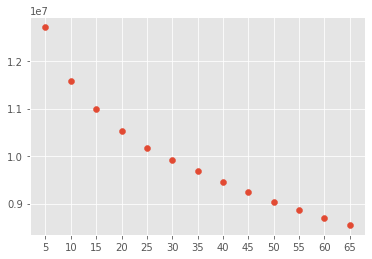

In [23]:
find_best_k_for_kmeans(cluster_range, x)

Судя по нашему графику, лучшее значение гиперпараметра k в kmeans - между 10 и 15

In [17]:
'''Сумма расстояний между точками-фреймами'''
kmeans.inertia_

11581201.245799666

In [98]:
'''Разделяю на кластеры'''
kmeans = KMeans(n_clusters=10,n_jobs=-1, random_state=22)
kmeans.fit(x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=22, tol=0.0001, verbose=0)

In [99]:
'''Создаю словарь, в котором указано, в какой кластер какой кадр попал'''
groups = {}
for file, cluster in zip(filenames, kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [100]:
'''Вместо кратких названий из filenames делаю просто номера кадров'''
graph_axes = {int(value[:value.find('_')]): key for key in groups.keys() for value in groups[key]}

In [101]:
graph_axes 

{2609: 7,
 5735: 7,
 5029: 7,
 2265: 7,
 5445: 7,
 379: 7,
 6446: 7,
 4169: 7,
 4443: 7,
 1266: 7,
 6670: 7,
 4396: 7,
 4505: 7,
 1116: 7,
 6500: 7,
 2818: 7,
 5862: 7,
 2997: 7,
 6861: 7,
 6050: 7,
 559: 7,
 6927: 7,
 910: 7,
 1208: 7,
 121: 7,
 6102: 7,
 6791: 7,
 3661: 7,
 251: 7,
 4041: 7,
 4088: 7,
 5876: 7,
 537: 7,
 6722: 7,
 4382: 7,
 6664: 7,
 6980: 7,
 6949: 7,
 4457: 7,
 6452: 7,
 5498: 7,
 2271: 7,
 2101: 7,
 5721: 7,
 6409: 7,
 4126: 7,
 100: 7,
 4583: 7,
 6065: 7,
 1190: 7,
 5857: 7,
 5911: 7,
 385: 7,
 4476: 7,
 3583: 7,
 499: 7,
 6645: 7,
 2857: 7,
 7196: 7,
 2120: 7,
 5464: 7,
 7182: 7,
 6651: 7,
 6698: 7,
 4462: 7,
 1071: 7,
 391: 7,
 672: 7,
 1301: 7,
 502: 7,
 6717: 7,
 5905: 7,
 2839: 7,
 5558: 7,
 3979: 7,
 6071: 7,
 3462: 7,
 6137: 7,
 3602: 7,
 1431: 7,
 6027: 7,
 4022: 7,
 468: 7,
 6950: 7,
 4487: 7,
 374: 7,
 697: 7,
 1094: 7,
 5448: 7,
 2268: 7,
 2118: 7,
 4328: 7,
 1211: 7,
 6607: 7,
 6431: 7,
 6741: 7,
 6788: 7,
 1999: 7,
 3164: 7,
 5432: 7,
 5560: 7,
 4085

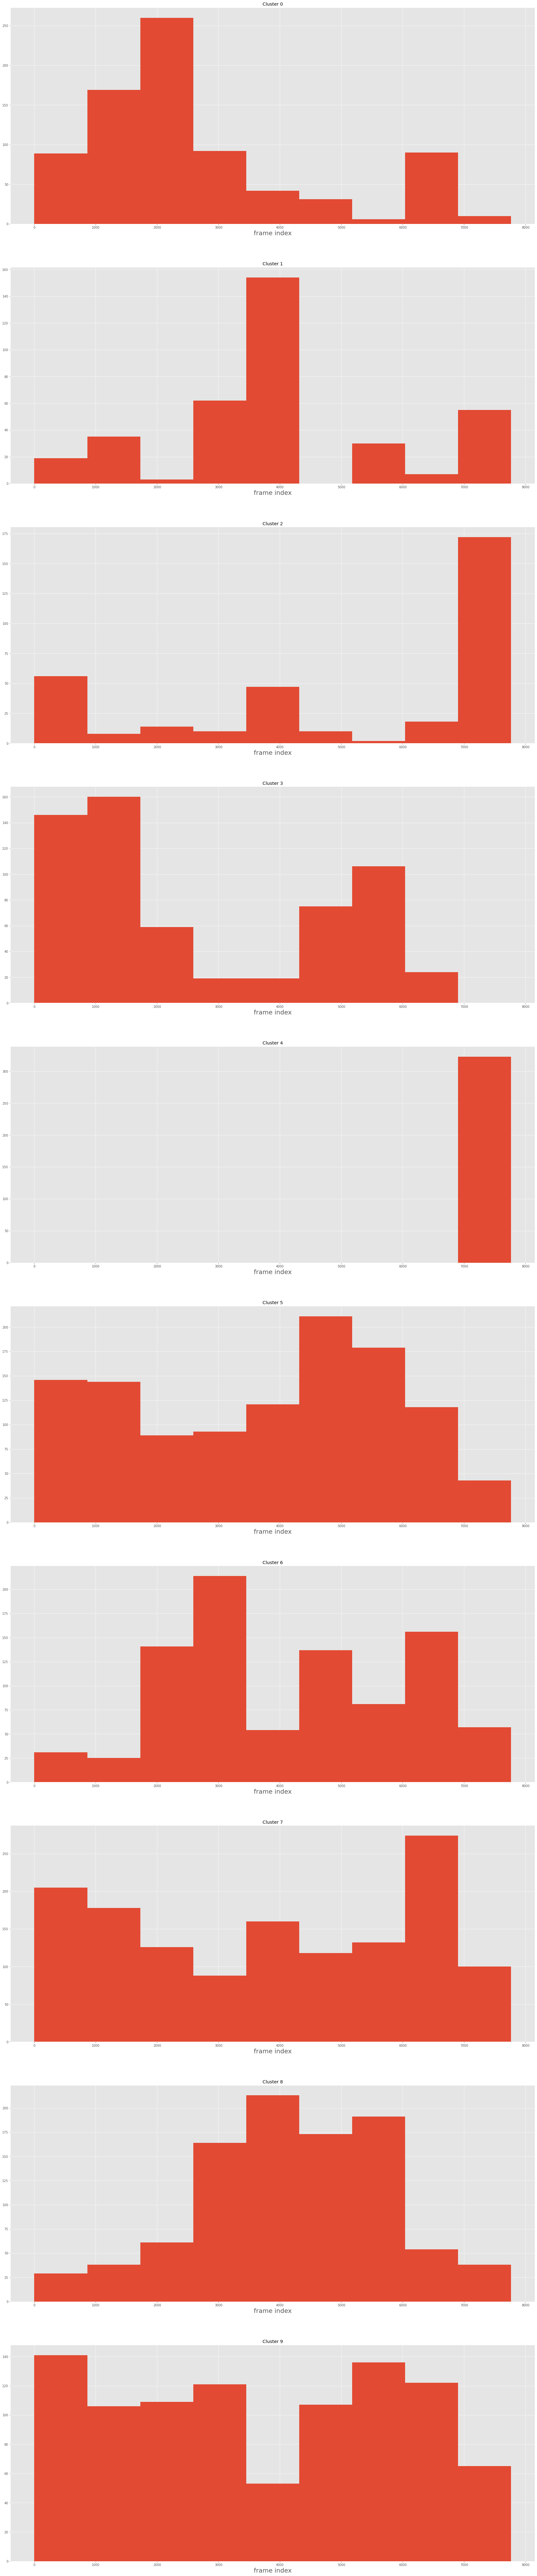

In [113]:
'''Строю гистограммы распределения кадров по кластерам, по x - номера кадров, по y - их количество в определенном
кластере'''
bins_num = 10
fig, plots = plt.subplots(10, 1, figsize=(30, 150))
for i in range(10):
    #len(kmeans) = num frames
    plots[i].hist([int(key[:key.find('_')]) for key in groups[i]], bins=np.linspace(0, len(kmeans.labels_),  bins_num))
    plots[i].set_title('Cluster {}'.format(i))
    plots[i].set_xlabel('frame index', fontsize=20)
plt.show()

In [17]:
'''Функция, с помощью которой можно просто вывести кадры, попавшие в определенный кластер, горизонтально, без
построения каких-либо графиков'''
def showImagesHorizontally(list_of_imgs_names, 
                           img_size=(440, 440),
                           folder_path='/Users/tonleon/Documents/GitHub/Diploma/Films/2012_frames/'):
    list_of_array_imgs = [cv2.imread(folder_path + img_name) for img_name in list_of_imgs_names]
    fig = plt.figure(figsize=img_size)
    columns = 6
    rows = 20
    for i, image in enumerate(list_of_array_imgs):
        ax = fig.add_subplot(rows, columns, i+1)
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb, cmap='Greys_r')
        plt.axis('off')
    plt.show()

In [115]:
'''Более полные пути к нашим кадрам, чтобы мы могли их выводить на графике'''
src = ['2012_frames/{}_frame.jpg'.format(i) for i in graph_axes.keys()] 

In [121]:
'''По оси x - названия кластеров, по оси y - номера кадров, видно, что в 4 кластер, гистограмма которого есть
в т.ч. выше и котороая отличается от других, поскольку она состоит лишь из одного столбца, попали титры, это
черный кластер. Кластер 1 оказывется кластером съемок на природе, он очень светлый, туда попали кадры зимние и
летние'''
output_notebook()

source = ColumnDataSource(data=dict(
    x= list(graph_axes.values()),
    y= list(graph_axes.keys()),
    desc=list(graph_axes.keys()),
    imgs=src,
    fonts = ['<i>trailer</i>'] * len(src)
))

TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" height="187" alt="@imgs" width=333""
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
        <div>
            <span style="font-size: 17px; font-weight: bold;">@desc</span>
            <span style="font-size: 15px; color: #966; alpha: 0.25">[$index]</span>
        </div>
        <div>
            <span>@fonts{safe}</span>
        </div>
        <div>
            <span style="font-size: 15px;">Location</span>
            <span style="font-size: 10px; color: #696;  alpha: 0.25">($x, $y)</span>
        </div>
    </div>
"""

p = figure(plot_width=1000, plot_height=600, tooltips=TOOLTIPS,
           title="Anna Karenina 2012")

p.circle('x', 'y', size=15, alpha=0.50, color='#62b696', source=source)

show(p)

Loading BokehJS ...

In [160]:
colors = ['red', 
          'rosybrown',
          'royalblue',
 'saddlebrown',
 'salmon',
 'sandybrown',
 'seagreen',
 'seashell',
 'sienna',
 'silver',
'skyblue']

In [161]:
labels_2_colors = {i: color for i, color in enumerate(colors)}

In [168]:
fill_colors = [labels_2_colors[label] for label in kmeans.labels_]
fill_colors

['seashell',
 'red',
 'seashell',
 'salmon',
 'seashell',
 'saddlebrown',
 'seagreen',
 'saddlebrown',
 'seagreen',
 'salmon',
 'seagreen',
 'salmon',
 'royalblue',
 'seagreen',
 'seagreen',
 'sandybrown',
 'seagreen',
 'seashell',
 'sienna',
 'salmon',
 'salmon',
 'sienna',
 'red',
 'sienna',
 'seashell',
 'seashell',
 'seashell',
 'sandybrown',
 'sienna',
 'sienna',
 'sandybrown',
 'saddlebrown',
 'red',
 'sienna',
 'silver',
 'red',
 'seashell',
 'seashell',
 'red',
 'seashell',
 'silver',
 'sandybrown',
 'silver',
 'seashell',
 'sandybrown',
 'seashell',
 'saddlebrown',
 'seagreen',
 'sienna',
 'seashell',
 'sandybrown',
 'sandybrown',
 'silver',
 'seashell',
 'sienna',
 'silver',
 'seashell',
 'sienna',
 'sandybrown',
 'sienna',
 'sandybrown',
 'silver',
 'saddlebrown',
 'saddlebrown',
 'royalblue',
 'sienna',
 'sandybrown',
 'seagreen',
 'royalblue',
 'seashell',
 'sandybrown',
 'red',
 'seagreen',
 'sienna',
 'saddlebrown',
 'seagreen',
 'red',
 'saddlebrown',
 'saddlebrown',
 '

In [102]:
len(graph_axes)

7764

In [104]:
import collections
# graph_axes_ordered = collections.OrderedDict(sorted(graph_axes.items()))
graph_axes_ordered = dict(sorted(graph_axes.items()))
graph_axes_ordered

{1: 2,
 2: 2,
 3: 2,
 4: 2,
 5: 8,
 6: 2,
 7: 2,
 8: 2,
 9: 2,
 10: 2,
 11: 2,
 12: 2,
 13: 2,
 14: 2,
 15: 2,
 16: 2,
 17: 2,
 18: 2,
 19: 2,
 20: 2,
 21: 2,
 22: 2,
 23: 2,
 24: 2,
 25: 2,
 26: 2,
 27: 2,
 28: 2,
 29: 2,
 30: 2,
 31: 2,
 32: 2,
 33: 2,
 34: 2,
 35: 2,
 36: 2,
 37: 2,
 38: 2,
 39: 2,
 40: 2,
 41: 2,
 42: 2,
 43: 9,
 44: 9,
 45: 9,
 46: 9,
 47: 9,
 48: 9,
 49: 9,
 50: 9,
 51: 9,
 52: 9,
 53: 9,
 54: 9,
 55: 9,
 56: 9,
 57: 9,
 58: 9,
 59: 9,
 60: 9,
 61: 9,
 62: 9,
 63: 9,
 64: 9,
 65: 9,
 66: 9,
 67: 9,
 68: 9,
 69: 9,
 70: 9,
 71: 9,
 72: 9,
 73: 9,
 74: 9,
 75: 9,
 76: 9,
 77: 9,
 78: 9,
 79: 9,
 80: 2,
 81: 2,
 82: 2,
 83: 2,
 84: 2,
 85: 2,
 86: 2,
 87: 2,
 88: 2,
 89: 2,
 90: 9,
 91: 2,
 92: 2,
 93: 9,
 94: 9,
 95: 9,
 96: 9,
 97: 3,
 98: 7,
 99: 7,
 100: 7,
 101: 7,
 102: 7,
 103: 7,
 104: 7,
 105: 5,
 106: 7,
 107: 7,
 108: 7,
 109: 7,
 110: 8,
 111: 8,
 112: 7,
 113: 7,
 114: 8,
 115: 9,
 116: 9,
 117: 5,
 118: 0,
 119: 0,
 120: 7,
 121: 7,
 122: 7,
 123: 7,
 

In [184]:
output_notebook()

source = ColumnDataSource(data=dict(
    x= list(graph_axes_ordered.keys()),
    y= [0] * len(graph_axes_ordered),
    desc=list(graph_axes.keys()),
    imgs=src,
    fonts = ['<i>trailer</i>'] * len(src)
))

TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" height="187" alt="@imgs" width=333""
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
        <div>
            <span style="font-size: 17px; font-weight: bold;">@desc</span>
            <span style="font-size: 15px; color: #966; alpha: 0.25">[$index]</span>
        </div>
        <div>
            <span>@fonts{safe}</span>
        </div>
        <div>
            <span style="font-size: 15px;">Location</span>
            <span style="font-size: 10px; color: #696;  alpha: 0.25">($x, $y)</span>
        </div>
    </div>
"""

p = figure(plot_width=1000, plot_height=600, tooltips=TOOLTIPS,
           title="Anna Karenina 2012")

p.circle(list(graph_axes.keys()), [0] * len(graph_axes), size=15, alpha=0.50, fill_color=fill_colors)

show(p)

Loading BokehJS ...

# Фильм 1967

In [34]:
'''Путь к кадрам фильма'''
path_1967 = '/Users/tonleon/Documents/GitHub/Diploma/Films/1967_frames'
shots_1967 = add_image_names_2_list(path_1967)

In [35]:
shots_1967

['2609_frame.jpg',
 '2323_frame.jpg',
 '5735_frame.jpg',
 '7730_frame.jpg',
 '5029_frame.jpg',
 '5503_frame.jpg',
 '2115_frame.jpg',
 '97_frame.jpg',
 '5818_frame.jpg',
 '7506_frame.jpg',
 '2924_frame.jpg',
 '7676_frame.jpg',
 '7395_frame.jpg',
 '5359_frame.jpg',
 '5390_frame.jpg',
 '5673_frame.jpg',
 '2786_frame.jpg',
 '2265_frame.jpg',
 '2862_frame.jpg',
 '7489_frame.jpg',
 '7440_frame.jpg',
 '5997_frame.jpg',
 '2579_frame.jpg',
 '7992_frame.jpg',
 '2053_frame.jpg',
 '5445_frame.jpg',
 '379_frame.jpg',
 '6446_frame.jpg',
 '653_frame.jpg',
 '3864_frame.jpg',
 '8171_frame.jpg',
 '4991_frame.jpg',
 '8492_frame.jpg',
 '1099_frame.jpg',
 '4958_frame.jpg',
 '1050_frame.jpg',
 '3055_frame.jpg',
 '6994_frame.jpg',
 '1861_frame.jpg',
 '4169_frame.jpg',
 '4443_frame.jpg',
 '1785_frame.jpg',
 '1266_frame.jpg',
 '8347_frame.jpg',
 '186_frame.jpg',
 '465_frame.jpg',
 '6393_frame.jpg',
 '6670_frame.jpg',
 '4675_frame.jpg',
 '4396_frame.jpg',
 '3749_frame.jpg',
 '3263_frame.jpg',
 '3780_frame.jpg',

In [53]:
'''Энергозатратный чанк, изменяет размерность каждого фрейма'''
def feat_of_frames_after_model_work(path, model):
    path = path
    shots = add_image_names_2_list(path)
    
    data = {}

    for shot in shots:
        feat = extract_features(shot, model)
        data[shot] = feat

    filenames = np.array(list(data.keys()))

    # get a list of just the features
    feat = np.array(list(data.values()))

    # reshape so that there are 210 samples of 4096 vectors
    feat = feat.reshape(-1,4096)
    
    return shots, data, filenames, feat

In [54]:
shots_1967, data_1967, filenames_1967, feat_1967 = feat_of_frames_after_model_work('/Users/tonleon/Documents/GitHub/Diploma/Films/1967_frames', model)

In [55]:
file = csv.writer(open("/Users/tonleon/Documents/GitHub/Diploma/Films/Data/Features_1967.csv", "w"))
for key, val in data_1967.items():
    file.writerow([key, val])

In [56]:
pca_1967 = PCA(n_components=150, random_state=22)
pca_1967.fit(feat_1967)
x_1967 = pca_1967.transform(feat_1967)

In [57]:
'''Опять сохраняю'''
savetxt('PCA_1967.csv', x_1967, delimiter=',')

Working on clusters number equal to 5...
Working on clusters number equal to 10...
Working on clusters number equal to 15...
Working on clusters number equal to 20...
Working on clusters number equal to 25...
Working on clusters number equal to 30...
Working on clusters number equal to 35...
Working on clusters number equal to 40...
Working on clusters number equal to 45...
Working on clusters number equal to 50...
Working on clusters number equal to 55...
Working on clusters number equal to 60...
Working on clusters number equal to 65...


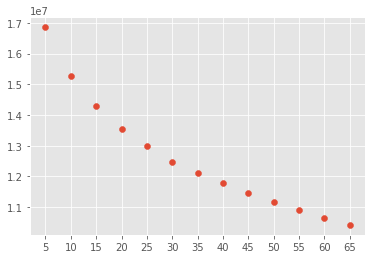

In [60]:
find_best_k_for_kmeans(cluster_range, x_1967)

In [86]:
best_n_clusters = 15

In [87]:
kmeans = KMeans(n_clusters=best_n_clusters,n_jobs=-1, random_state=22)
kmeans.fit(x_1967)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=15, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=22, tol=0.0001, verbose=0)

In [88]:
groups_1967 = {}
for file, cluster in zip(filenames_1967, kmeans.labels_):
    if cluster not in groups_1967.keys():
        groups_1967[cluster] = []
        groups_1967[cluster].append(file)
    else:
        groups_1967[cluster].append(file)
graph_axes_1967 = {int(value[:value.find('_')]): key for key in groups_1967.keys() for value in groups_1967[key]}

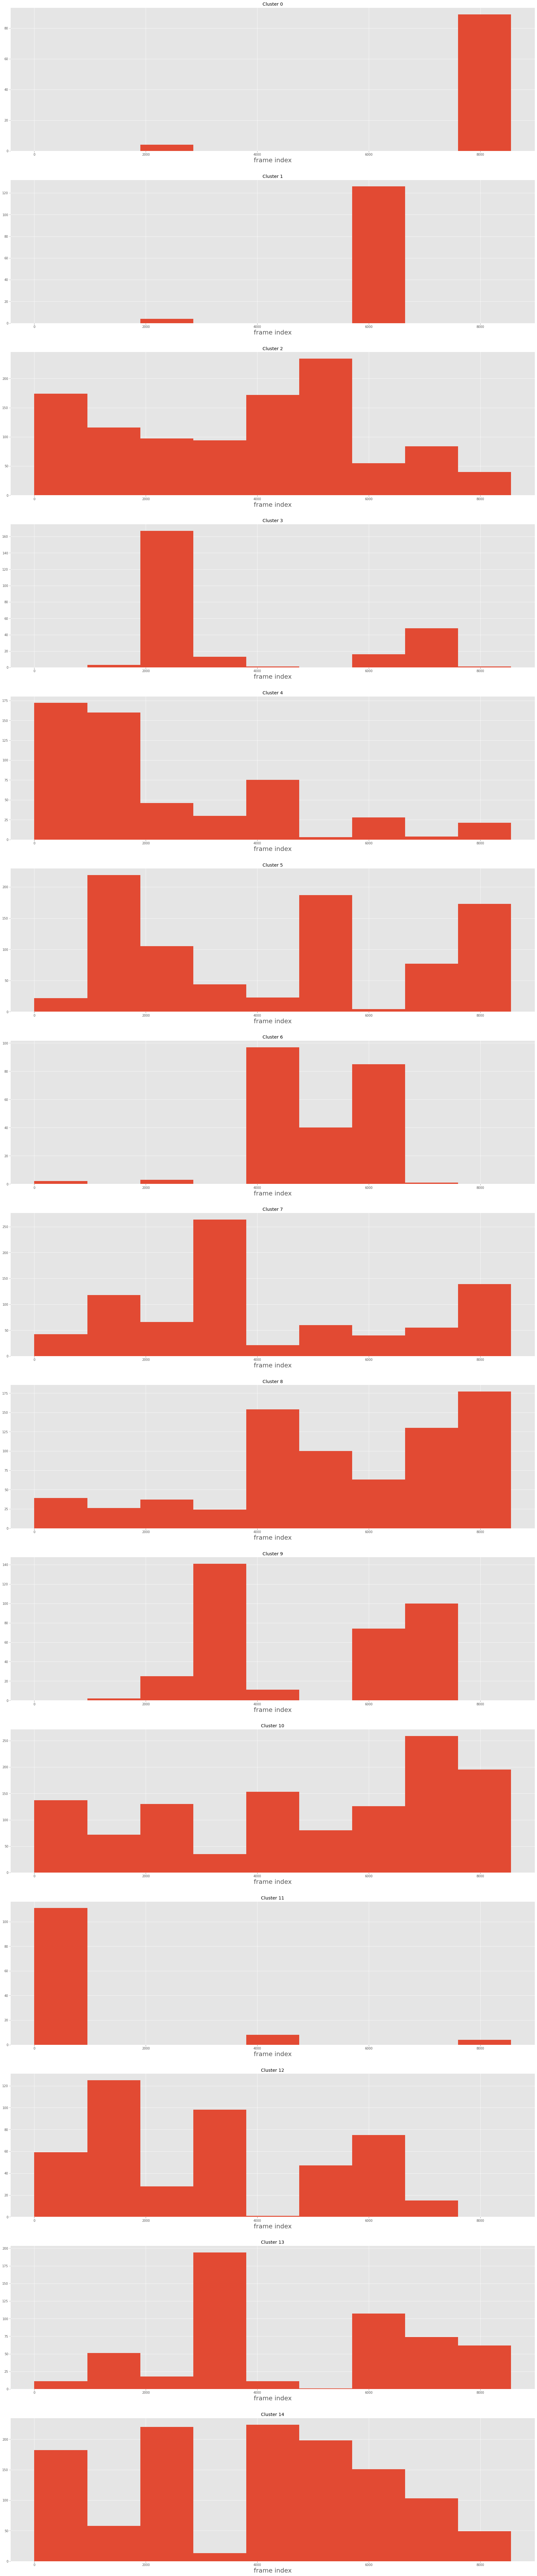

In [89]:
bins_num = 10
fig, plots = plt.subplots(best_n_clusters, 1, figsize=(30, 150))
for i in range(best_n_clusters):
    #len(kmeans) = num frames
    plots[i].hist([int(key[:key.find('_')]) for key in groups_1967[i]], bins=np.linspace(0, len(kmeans.labels_),  bins_num))
    plots[i].set_title('Cluster {}'.format(i))
    plots[i].set_xlabel('frame index', fontsize=20)
plt.show()

In [109]:
len(src_1967)

7764

In [108]:
src_1967 = ['1967_frames/{}_frame.jpg'.format(i) for i in graph_axes.keys()] 
output_notebook()

source = ColumnDataSource(data=dict(
    x= list(graph_axes_1967.values()),
    y= list(graph_axes_1967.keys()),
    desc=list(graph_axes_1967.keys()),
    imgs=src_1967,
    fonts = ['<i>trailer</i>'] * len(src_1967)
))

TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" height="93" alt="@imgs" width=167""
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;">@desc</span>
            <span style="font-size: 11px; color: #966; alpha: 0.25">[$index]</span>
        </div>
        <div>
            <span>@fonts{safe}</span>
        </div>
        <div>
            <span style="font-size: 11px;">Location</span>
            <span style="font-size: 10px; color: #696;  alpha: 0.25">($x, $y)</span>
        </div>
    </div>
"""

p = figure(plot_width=1000, plot_height=600, tooltips=TOOLTIPS,
           title="Anna Karenina 1967")

p.circle('x', 'y', size=15, alpha=0.50, color='#62b696', source=source)

show(p)

Loading BokehJS ...